# 1. Loading the required libraries 

In [35]:
# Import the required libraries

# Data manipulation and math operations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt  # For Matplotlib visualizations
import seaborn as sns            # For Seaborn visualizations
import plotly.express as px      # For interactive visualizations with Plotly
# %matplotlib inline  # Uncomment for Jupyter notebooks to display plots inline

# System libraries
import warnings
import sys
import os
# Ignore all warnings (useful for ignoring non-critical warnings)
warnings.filterwarnings("ignore")

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import utils library with custom functions
from utils_finance import *

# 2. Data management: Finding, loading and concat all years of the data, saving it 

In [36]:
# Retrieving data

# Path to the neighboring 'data' folder in the local repository
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
print(data_path)

# CSV files from DKB have a cryptic header; skip the first rows to make it readable
headerSize = 4

# List to store each DataFrame for later concatenation
dataframes = []

# Iterate through all files in the Data directory
for filename in os.listdir(data_path):
    # Skip "Data_All_Years.csv" if it already exists
    if filename == "Data_All_Years.csv":
        continue
    # Skip the training data for the ML model
    if filename == "Training_Data.csv":
        continue
    
    # Check if the file is a .csv file
    if filename.endswith('.csv'):
        # Create the full path to the file
        file_path = os.path.join(data_path, filename)

        # Extract the last 4 digits of the filename (assuming they represent the year)
        last_four_digits = filename[-8:-4]
        
        # Make the year variable
        year = int(last_four_digits)

        # Read the .csv file into a DataFrame
        print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path, sep=',', skiprows=headerSize, header=0, encoding='utf-8-sig')

        # Save the DataFrame under a dynamic name
        globals()[f'df_{last_four_digits}'] = df

        # Append the DataFrame to the list for concatenation
        dataframes.append(df)

        # Display the shape and column names of the DataFrame
        print('Shape:', df.shape)
        print('Column names:', df.columns)

# Concatenate all data to a single DataFrame
df_all_years = pd.concat(dataframes, ignore_index=True)

# Save the concatenated DataFrame to "Data_All_Years.csv"
output_path = os.path.join(data_path, "Data_All_Years.csv")
df_all_years.to_csv(output_path, index=False, sep=';')
print(f"Concatenated DataFrame saved to: {output_path}")


/Users/tillo/Repositoriums/FinanceGrouper/data
Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_transactions_2024.csv
Shape: (551, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag (€)', 'Gläubiger-ID', 'Mandatsreferenz', 'Kundenreferenz'],
      dtype='object')
Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_transactions2023.csv
Shape: (533, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag (€)', 'Gläubiger-ID', 'Mandatsreferenz', 'Kundenreferenz'],
      dtype='object')
Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_Transactions_2022.csv
Shape: (437, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendu

In [37]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 437 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status                 Zahlungspflichtige*r  \
0      30.12.22     01.01.23  Gebucht                               DKB AG   
1      30.12.22     30.12.22  Gebucht                     Tillmann Stralka   
2      29.12.22     29.12.22  Gebucht                               ISSUER   
3      29.12.22     29.12.22  Gebucht   Hauptkasse des Freistaates Sachsen   
4      28.12.22     28.12.22  Gebucht  Helga Jakob-Stralka Norbert Stralka   

                            Zahlungsempfänger*in  \
0                                         DKB AG   
1  AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND   
2                              PAYPAL .SPORTMORE   
3                               STRALKA TILLMANN   
4                               Tillmann Stralka   

                                    Verwendungszweck Umsatztyp  \
0  Abrechnung 30.12.2022 siehe Anlage Abrechnung 

# 3. First cleaning of data set
+ deleting empty rows and columns 
+ fixing Euro ',' and '.' problem in numbers 
+ changing type of columns to numerical (floats) and types (object)
+ filter all entrances which have very long empty entrys and make them to only one ' '

In [38]:
### Deleting empty columns and rows for each df before saving it in a global variable 
# Identify columns that contain only NaN values
nan_columns = df.columns[df.isna().all()].tolist()    
# Drop the columns with only NaN values
df.drop(columns=nan_columns, inplace=True)
# Delete all rows that are completely empty (i.e., contain only NaN values)
empty_rows = df[df.isna().all(axis=1)].index
df.drop(index=empty_rows, inplace=True)

Set type of data of the columns 

In [39]:
# Fix US / EU decimal-point/comma
df['Betrag (€)'] = df['Betrag (€)'].str.replace('.','')
df['Betrag (€)'] = df['Betrag (€)'].str.replace(',','.')


In [40]:

# All columns will be set accordingly as dtype to what sort of stuff they contain 
df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], format='%d.%m.%y', errors='coerce')
df['Wertstellung'] = pd.to_datetime(df['Wertstellung'], format='%d.%m.%y', errors='coerce')
df['Status'] = df['Status'].astype('category')
df['Zahlungspflichtige*r'] = df['Zahlungspflichtige*r'].astype('string')
df['Zahlungsempfänger*in'] = df['Zahlungsempfänger*in'].astype('string')
df['Verwendungszweck'] = df['Verwendungszweck'].astype('string')
df['Umsatztyp'] = df['Umsatztyp'].astype('category')
df['IBAN'] = df['IBAN'].astype('string')

# Make sure euro is set to string 
df['Betrag (€)'] = df['Betrag (€)'].astype(float)

df['Gläubiger-ID'] = df['Gläubiger-ID'].astype('string')
df['Mandatsreferenz'] = df['Mandatsreferenz'].astype('string')
df['Kundenreferenz'] = df['Kundenreferenz'].astype('string')

#Check if it worked 
inspect_data(df)


🚀 Basic Data Overview
🗂 Shape of the DataFrame: 437 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status                 Zahlungspflichtige*r  \
0    2022-12-30   2023-01-01  Gebucht                               DKB AG   
1    2022-12-30   2022-12-30  Gebucht                     Tillmann Stralka   
2    2022-12-29   2022-12-29  Gebucht                               ISSUER   
3    2022-12-29   2022-12-29  Gebucht   Hauptkasse des Freistaates Sachsen   
4    2022-12-28   2022-12-28  Gebucht  Helga Jakob-Stralka Norbert Stralka   

                            Zahlungsempfänger*in  \
0                                         DKB AG   
1  AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND   
2                              PAYPAL .SPORTMORE   
3                               STRALKA TILLMANN   
4                               Tillmann Stralka   

                                    Verwendungszweck Umsatztyp  \
0  Abrechnung 30.12.2022 siehe Anlage Abrechnung 

In [41]:
# Function to replace multiple spaces and new lines with a single space
df = reduce_multiple_spaces_and_newlines(df)

# 4. Basic analysis of the data 
+ Calculate total income and expenses.
+ Determine monthly savings (income minus expenses).
+ Identify the largest expenses and sources of income.

In [42]:
# Performs basic financial analysis including total income, expenses, and largest transactions
basic_analysis(df)


Total Income: €28136.24
Total Expenses: €-25589.67
Monthly Savings:
month
2022-01    1406.19
2022-02     605.79
2022-03     226.67
2022-04    -730.55
2022-05   -1215.11
2022-06    -135.91
2022-07    -753.87
2022-08     801.41
2022-09     -50.73
2022-10    -119.88
2022-11    1730.14
2022-12     782.42
Freq: M, Name: Betrag (€), dtype: float64

Largest Expense:
    Buchungsdatum Zahlungsempfänger*in  Betrag (€)
182    2022-08-17             MITOS AE     -1660.0

Largest Income:
    Buchungsdatum                Zahlungspflichtige*r  Betrag (€)
411    2022-02-25  Hauptkasse des Freistaates Sachsen     2233.19

Most frequent income source: Hauptkasse des Freistaates Sachsen
Most frequent outgoing target: 3273 Konsum Rosa Luxemb


# 5. Income and Expense Categorization
+ Categorize transactions by Umsatztyp (e.g., groceries, rent, salary) to provide a breakdown of expenses and income per category. 
+ This helps understand which categories contribute the most to expenses and income.

In [43]:
# Group by 'Umsatztyp' and calculate total income and expenses per category
analyze_by_category(df)


Total by Category:
Umsatztyp
Ausgang   -25589.67
Eingang    28136.24
Name: Betrag (€), dtype: float64


# 6. Income vs Expense Trend Over Time 
+ Create a time series analysis to visualize income and expenses trends over time (e.g., monthly, quarterly).


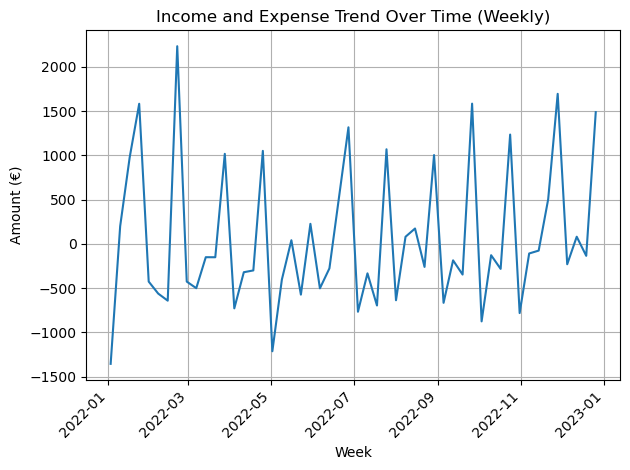

In [44]:
# Creates a time series analysis of income and expenses over time
income_expense_trend(df)


# 7. Average Monthly Income/Expense
Calculate the average monthly income and expense to get an overall view of typical monthly financial activity.

In [45]:
# Calculates average monthly income and expenses.
average_monthly_stats(df)


Average Monthly Income: €2344.69
Average Monthly Expenses: €-2132.47


# 8. Recurring Transactions Detection
Identify recurring transactions such as regular payments (e.g., rent, subscriptions) or income (e.g., salary) based on similar amounts and descriptions.

In [46]:
# Identifies recurring transactions based on recipient and amount
# Call the function and display the first few rows of the recurring transactions
recurring, recurring_summary = detect_recurring_transactions(df)
recurring_summary.head()


Recurring Transactions:
    Buchungsdatum     Zahlungsempfänger*in  Betrag (€)  \
0      2022-12-30                   DKB AG         0.0   
6      2022-12-27        DB FERNVERKEHR AG        -3.6   
27     2022-12-12  Boulderhalle Leipzig Gm       -10.5   
31     2022-12-07  Boulderhalle Leipzig Gm        -8.0   
39     2022-12-05   Transact,Eisenbahnst53      -100.0   
..            ...                      ...         ...   
428    2022-01-12         TILLMANN STRALKA       -50.0   
430    2022-01-06         TILLMANN STRALKA      -200.0   
431    2022-01-06             DKB VISACARD      -300.0   
435    2022-01-03         MICHAEL STEUBING      -396.5   
436    2022-01-03             PAUL COLDITZ       -29.0   

                                      Verwendungszweck  
0    Abrechnung 30.12.2022 siehe Anlage Abrechnung ...  
6                               VISA Debitkartenumsatz  
27                              VISA Debitkartenumsatz  
31                              VISA Debitkartenum

,Zahlungsempfänger*in,Betrag (€),Count
20,TILLMANN STRALKA,-200.0,11
21,TILLMANN STRALKA,-50.0,11
11,PAUL COLDITZ,-29.0,10
3,Boulderhalle Leipzig Gm,-8.0,7
25,"Transact,Eisenbahnst53",-50.0,7


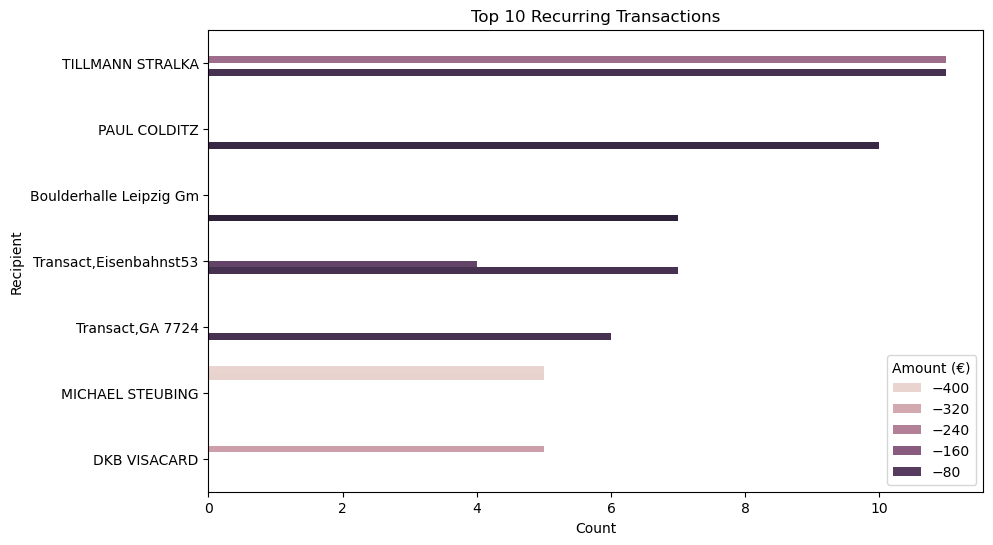

In [47]:
# Visualizes the top recurring transactions in a bar plot
plot_recurring_summary(recurring_summary)

# 9. Monthly Expense to Income Ratio
Calculate the expense-to-income ratio to determine how much of your income is spent each month.

In [48]:
# Calculates the expense-to-income ratio per month
expense_income_ratio(df)



Expense to Income Ratio per Month:
month
2022-01    0.637878
2022-02    0.728733
2022-03    0.856827
2022-04    1.387932
2022-05    1.645240
2022-06    1.082684
2022-07    1.473156
2022-08    0.808882
2022-09    1.027962
2022-10    1.072337
2022-11    0.498644
2022-12    0.662393
Freq: M, Name: Betrag (€), dtype: float64


# 10. Expense Breakdown by Vendor/Recipient
Provide a breakdown of total expenses by Zahlungsempfänger*in to identify who you are spending the most money on.

In [49]:
# Provides a breakdown of expenses by recipient
expenses_by_recipient(df)


Expenses by Recipient:
Zahlungsempfänger*in
MICHAEL STEUBING          -4050.00
DKB VISACARD              -3104.69
TILLMANN STRALKA          -2750.00
MITOS AE                  -1660.00
3273 Konsum Rosa Luxemb   -1448.71
                            ...   
POINT SUPERMARKT PROMEN      -2.94
STEINECKE'S HEIDEBROT        -2.75
Studentenwerk N/O            -1.55
SumUp .Das Unikat GmbH       -1.20
ASPIT DIREZ. USCITA -        -0.80
Name: Betrag (€), Length: 158, dtype: float64


# 11. Outlier Detection
Identify unusually large transactions by detecting outliers (e.g., large expenses that are significantly different from the average).

In [50]:
# Identifies unusual transactions using standard deviation
detect_outliers(df)


Outliers:
    Buchungsdatum  Betrag (€)        Verwendungszweck
3      2022-12-29     1643.75           BEZUEGE 12.22
45     2022-11-29     2196.23           BEZUEGE 11.22
92     2022-10-27     1593.28           BEZUEGE 10.22
125    2022-09-29     1814.28           BEZUEGE 09.22
166    2022-08-30     1593.28           BEZUEGE 08.22
182    2022-08-17    -1660.00  VISA Debitkartenumsatz
183    2022-08-16     2000.00         Kreta-Konferenz
207    2022-07-28     1593.28           BEZUEGE 07.22
244    2022-06-29     1643.73           BEZUEGE 06.22
291    2022-05-30     1583.19           BEZUEGE 05.22
341    2022-04-28     1583.19           BEZUEGE 04.22
391    2022-03-30     1583.19           BEZUEGE 03.22
411    2022-02-25     2233.19           BEZUEGE 02.22
422    2022-01-28     1583.19           BEZUEGE 01.22
425    2022-01-17     2000.00          Mexico Support


# 12. Savings Percentage
Calculate the percentage of income saved each month.


Savings Percentage per Month:
month
2022-01    36.212238
2022-02    27.126666
2022-03    14.317296
2022-04   -38.793218
2022-05   -64.524026
2022-06    -8.268390
2022-07   -47.315601
2022-08    19.111769
2022-09    -2.796151
2022-10    -7.233670
2022-11    50.135616
2022-12    33.760652
Freq: M, Name: Betrag (€), dtype: float64


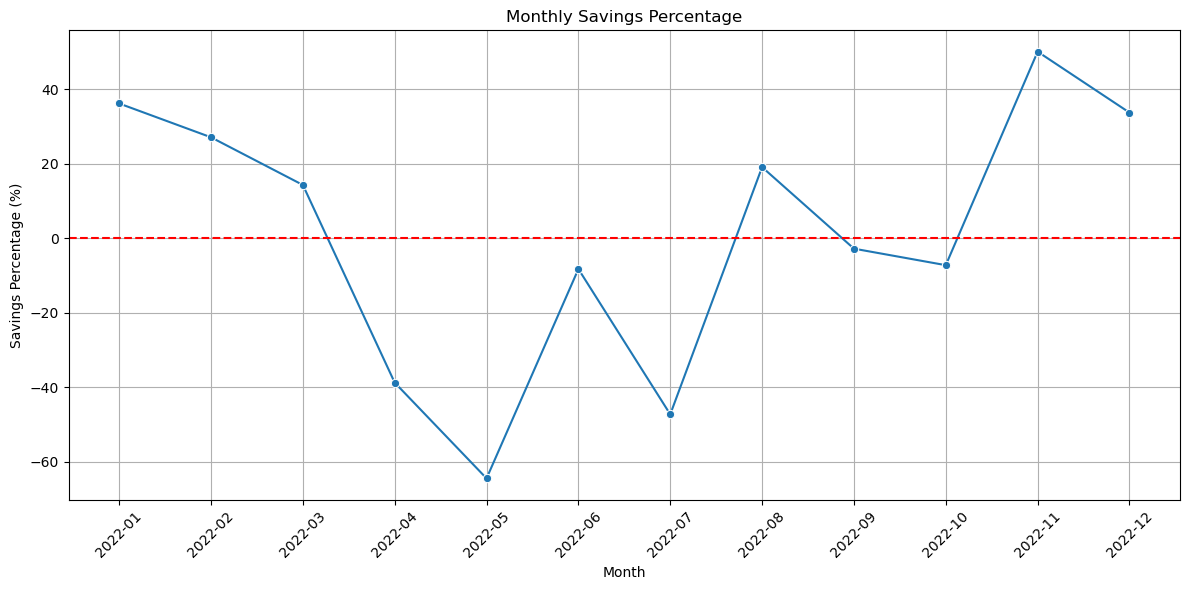

In [51]:
# Calculates and visualizes monthly savings percentage
savings_percentage(df)

# 13. Cash Flow Stability
Calculate cash flow volatility to measure the consistency of your monthly income and expenses.


Cash Flow Volatility: 4.19


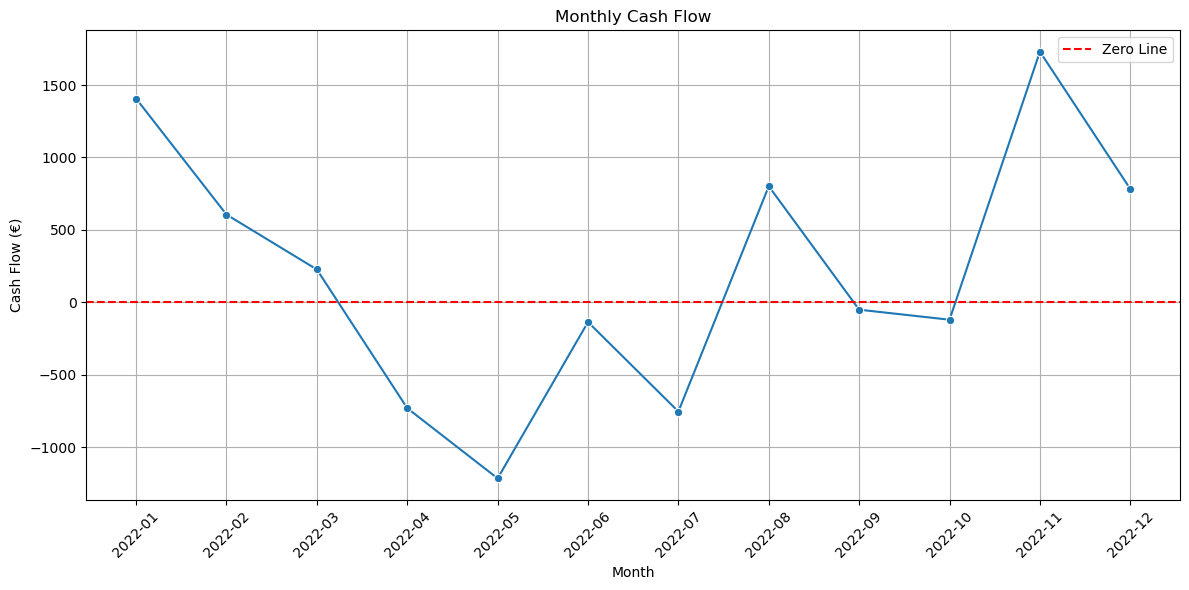

In [52]:
# Calculates and visualizes cash flow stability over time
cash_flow_volatility(df)

# 14. Income Sources Breakdown
Break down the sources of income (e.g., salary, refunds) by Zahlungspflichtige*r and analyze which contribute the most.


Income by Source:
Zahlungspflichtige*r
Hauptkasse des Freistaates Sachsen                                21167.58
Helga Jakob-Stralka Norbert Stralka                                2162.87
Norbert Stralka und Helga Jakob-Stralka                            2050.00
Tillmann Stralka                                                   1141.47
KREDITKARTEN GELDANLAGE                                             600.00
ISSUER                                                              279.49
PayPal (Europe) S.a.r.l. et Cie., S.C.A. 22-24 Boulevard Royal      250.00
Sophia-Theresa Richter                                              200.00
ibug e.V.                                                           133.73
Richter, Sophia-Theresa                                             100.00
Sebastian Jung Hinterhaus, 1. Stock                                  50.00
WILDE MOHRE GMBH                                                      1.10
Name: Betrag (€), dtype: float64


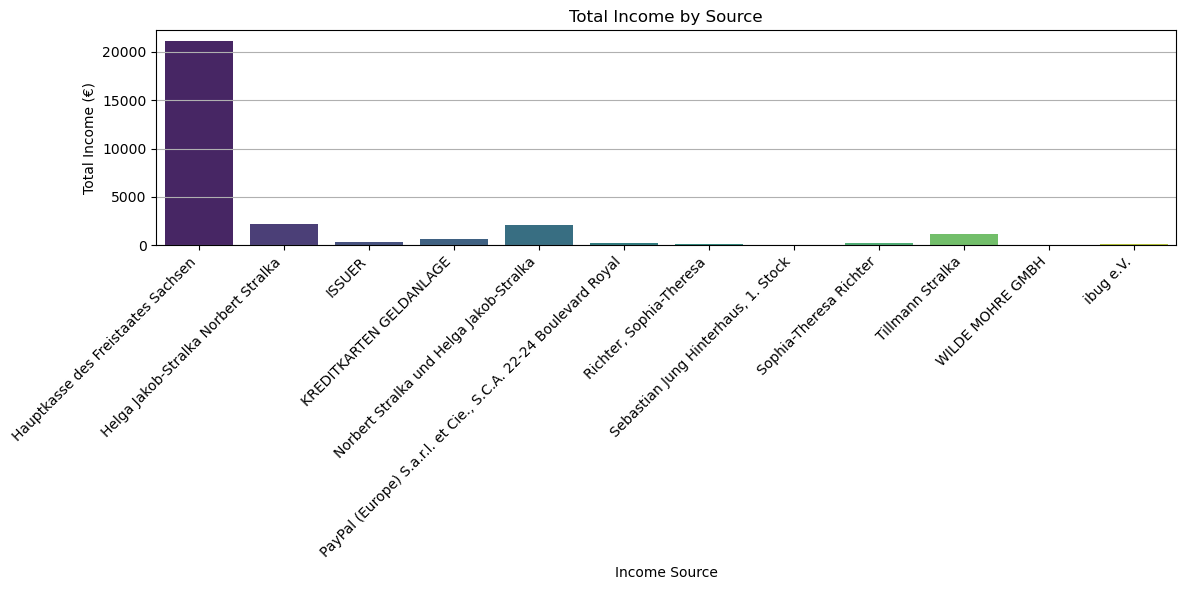

In [53]:
# Analyzes and visualizes income sources with bar plots
income_by_source(df)

# Plots 

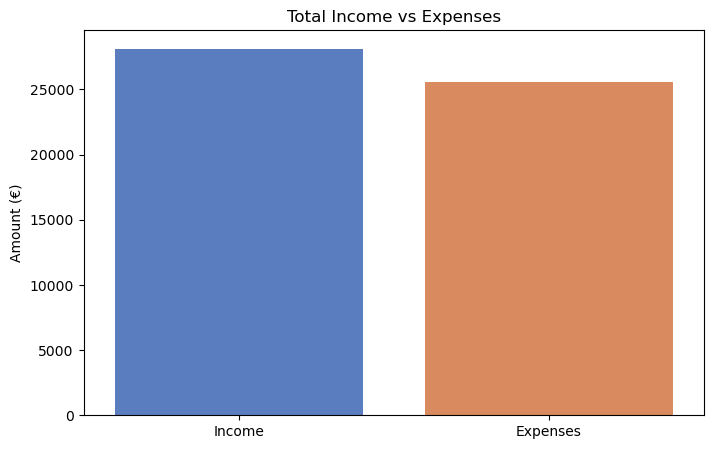

In [54]:
def plot_total_income_expenses(df):
    """
    Plots total income and expenses from the given DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame containing financial data with a 'Betrag (€)' column.
    """
    # Calculate total income: sum of all positive amounts in 'Betrag (€)'
    total_income = df[df['Betrag (€)'] > 0]['Betrag (€)'].sum()

    # Calculate total expenses: sum of all negative amounts in 'Betrag (€)' (make positive for display)
    total_expenses = df[df['Betrag (€)'] < 0]['Betrag (€)'].sum()

    # Prepare data for plotting as a dictionary
    totals = {'Income': total_income, 'Expenses': abs(total_expenses)}  # Convert expenses to positive

    # Create a bar plot using Seaborn
    plt.figure(figsize=(8, 5))  # Set figure size
    sns.barplot(x=list(totals.keys()), y=list(totals.values()), palette='muted')

    # Set the title and labels for the plot
    plt.title("Total Income vs Expenses")
    plt.ylabel("Amount (€)")
    
    # Show the plot
    plt.show()

plot_total_income_expenses(df)

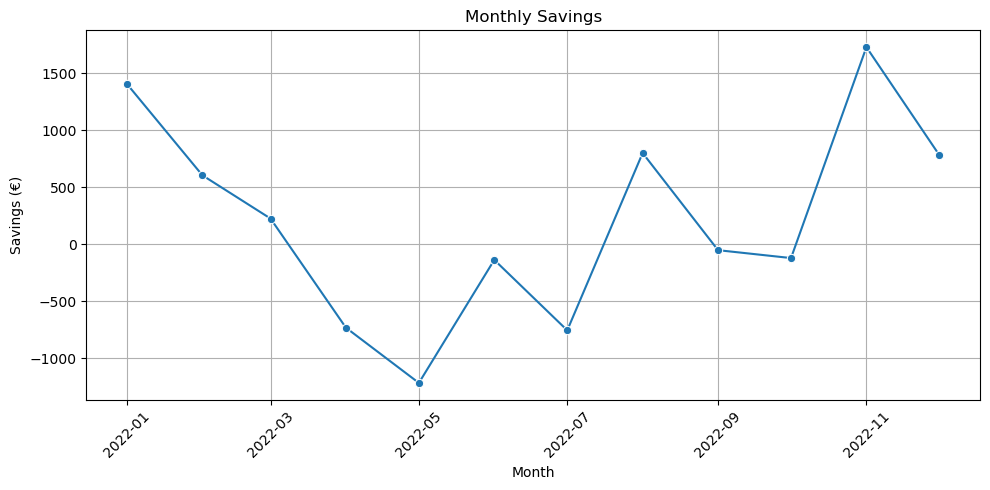

In [55]:
def plot_monthly_savings(df):
    """
    Plots monthly savings over time.
    
    Parameters:
    df (DataFrame): The DataFrame containing financial data with 'Buchungsdatum' and 'Betrag (€)' columns.
    """
    # Ensure 'Buchungsdatum' is in datetime format
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], errors='coerce')

    # Group by month and calculate total savings (income minus expenses)
    df['month'] = df['Buchungsdatum'].dt.to_period('M')  # Extract month
    monthly_savings = df.groupby('month')['Betrag (€)'].sum().reset_index()

    # Convert 'month' back to a datetime object for plotting
    monthly_savings['month'] = monthly_savings['month'].dt.to_timestamp()

    # Plot
    plt.figure(figsize=(10, 5))  # Set figure size
    sns.lineplot(x='month', y='Betrag (€)', data=monthly_savings, marker='o')
    
    # Set title and labels
    plt.title('Monthly Savings')
    plt.ylabel('Savings (€)')
    plt.xlabel('Month')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid()  # Add grid for better visualization
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Example execution
# Assuming 'df' is your DataFrame containing financial transactions
plot_monthly_savings(df)

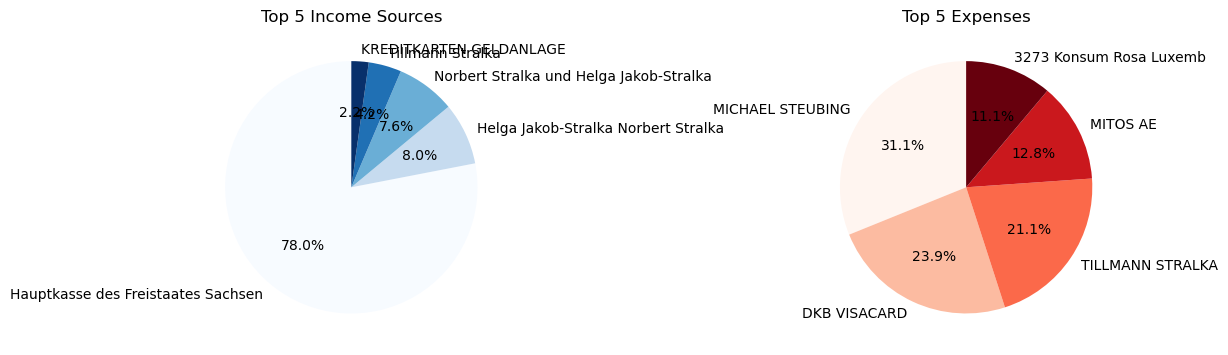

In [56]:
def plot_largest_expenses_income(df):
    """
    Plots the top 5 sources of income and the top 5 expenses in pie charts.
    
    Parameters:
    df (DataFrame): The DataFrame containing financial data with 'Betrag (€)', 'Zahlungspflichtige*r', and 'Zahlungsempfänger*in' columns.
    """
    # Top 5 sources of income
    top_income = df[df['Betrag (€)'] > 0].groupby('Zahlungspflichtige*r')['Betrag (€)'].sum().nlargest(5)
    
    # Top 5 expenses (convert to positive values for plotting)
    top_expenses = df[df['Betrag (€)'] < 0].groupby('Zahlungsempfänger*in')['Betrag (€)'].sum().nsmallest(5)
    top_expenses = top_expenses.abs()  # Convert expenses to positive values

    # Plot top 5 income sources
    plt.figure(figsize=(12, 6))  # Set figure size
    
    # Subplot for income
    plt.subplot(1, 2, 1)
    top_income.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Blues')
    plt.title("Top 5 Income Sources")
    plt.ylabel('')  # Hide the y-label for pie chart

    # Subplot for expenses
    plt.subplot(1, 2, 2)
    top_expenses.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Reds')
    plt.title("Top 5 Expenses")
    plt.ylabel('')  # Hide the y-label for pie chart
    
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Example execution
plot_largest_expenses_income(df)



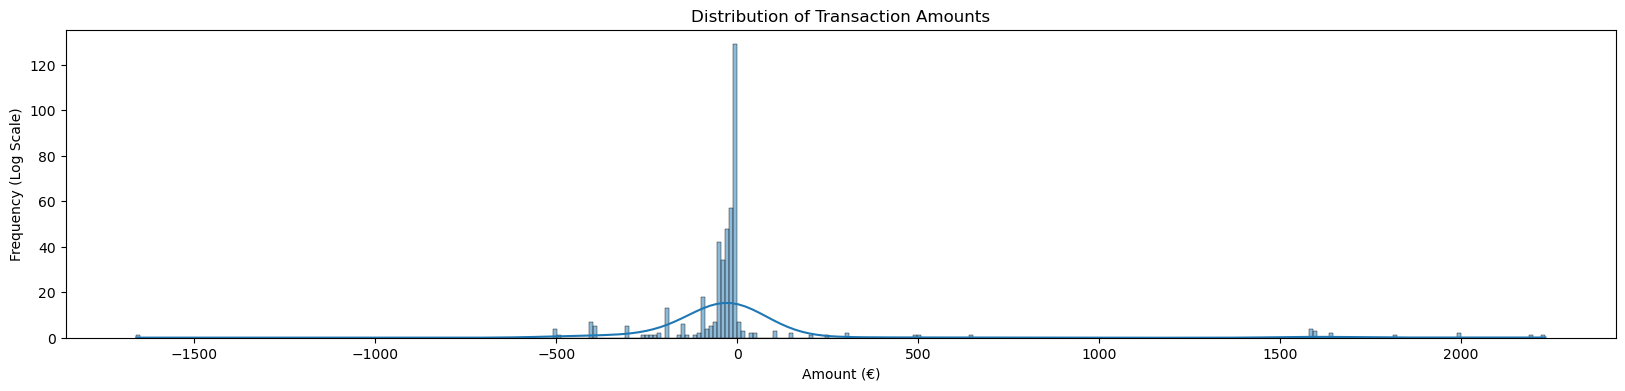

In [57]:
def plot_transaction_distribution(df):
    """
    Plots the distribution of transaction amounts using a histogram.

    Parameters:
    df (DataFrame): The DataFrame containing financial data with a 'Betrag (€)' column.

    This function generates a histogram that shows the frequency of transaction amounts,
    along with a Kernel Density Estimate (KDE) line to visualize the distribution's shape.
    The y-axis is set to a logarithmic scale to better visualize the distribution of 
    transaction amounts, especially when dealing with a wide range of values.
    """
    plt.figure(figsize=(20, 4)) 

    # Create the histogram with a KDE line
    sns.histplot(df['Betrag (€)'], kde=True)

    # Set the title and labels
    plt.title("Distribution of Transaction Amounts")
    plt.xlabel("Amount (€)")
    plt.ylabel("Frequency (Log Scale)")

    # Show the plot
    plt.show()

plot_transaction_distribution(df)    

In [58]:
def plot_monthly_income_vs_expenses(df):
    """
    Plots a stacked bar chart of monthly income versus expenses.

    Parameters:
    df (DataFrame): The DataFrame containing financial data with 'Buchungsdatum' and 'Betrag (€)' columns.

    This function calculates the total income and expenses per month and visualizes the data
    using a stacked bar chart. It categorizes the transactions as 'Income' or 'Expenses' based on
    the transaction amounts and groups them by month for comparison.
    """
    # Ensure 'Buchungsdatum' is in datetime format
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'])

    # Create a new column for the month
    df['month'] = df['Buchungsdatum'].dt.to_period('M').astype(str)  # Convert to string for better plotting

    # Classify transactions as Income or Expenses
    df['Type'] = df['Betrag (€)'].apply(lambda x: 'Income' if x > 0 else 'Expenses')
    
    # Group by month and transaction type, summing the amounts
    monthly_data = df.groupby(['month', 'Type'])['Betrag (€)'].sum().unstack().reset_index()

    # Plot using Plotly for interactive visualization
    fig = px.bar(monthly_data, x='month', y=['Income', 'Expenses'], 
                 title='Monthly Income vs Expenses',
                 labels={'value': 'Amount (€)', 'month': 'Month'},
                 barmode='stack')

    # Show the figure
    fig.show()

plot_monthly_income_vs_expenses(df)

# 15. Example for text and images into a overview pdf 

In [59]:
import io
import tempfile
import matplotlib.pyplot as plt
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch

# Listen für Text- und Plot-Speicher erstellen
text_outputs = []
plot_paths = []

# Beispiel: Text- und Plot-Erzeugung pro Schritt
def add_step(text, plot_function):
    # Text speichern
    text_outputs.append(text)
    
    # Plot erstellen und in einer temporären Datei speichern
    buf = io.BytesIO()
    plot_function()  # Plot-Erzeugung
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()  # Schließt den Plot
    
    # Temporäre Datei für den Plot erstellen
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    with open(temp_file.name, 'wb') as f:
        f.write(buf.getbuffer())
    plot_paths.append(temp_file.name)

# Beispiel-Plots für jeden Schritt
def example_plot_1():
    plt.plot([1, 2, 3], [1, 4, 9])
    plt.title("Quadratic Growth")

def example_plot_2():
    plt.plot([1, 2, 3], [1, 2, 3])
    plt.title("Linear Growth")

# Schritte hinzufügen
add_step("Text output for step 1", example_plot_1)
add_step("Text output for step 2", example_plot_2)

# PDF-Erstellung mit dynamischem Layout
def save_to_pdf(filename):
    c = canvas.Canvas(filename, pagesize=A4)
    width, height = A4
    margin = 1 * inch
    y_position = height - margin

    # Alle Texte und Plots hinzufügen
    for i, (text, plot_path) in enumerate(zip(text_outputs, plot_paths)):
        # Text hinzufügen, wenn Platz vorhanden ist, sonst neue Seite
        text_height = 0.5 * inch
        plot_height = 3 * inch
        spacing = 0.25 * inch  # Abstand zwischen Text und Bild

        # Prüfen, ob genug Platz auf der Seite für Text und Bild ist
        if y_position < margin + plot_height + text_height + spacing:
            c.showPage()  # Neue Seite
            y_position = height - margin  # Reset der y-Position

        # Text zeichnen
        c.drawString(margin, y_position, text)
        y_position -= text_height + spacing  # Position für das Bild anpassen

        # Plot zeichnen
        c.drawImage(plot_path, margin, y_position - plot_height, width=width - 2 * margin, height=plot_height)
        y_position -= plot_height + spacing  # y-Position für nächsten Abschnitt anpassen

    c.save()

# PDF speichern
save_to_pdf('output_summary.pdf')

# Temporäre Dateien löschen
import os
for path in plot_paths:
    os.remove(path)


# Next possible steps: 
# Man könnte noch alle adressen rausnehmen 
# Den DF nach Datum ascending ordnen, damit irgendwelche komischen ausstehenden zahlungen der DKB an den richtigen tag kommen 
# Relableing 
# Time Series analysis of income with prediction
# All functions in the src file -> better overview 
# Make all the output into a text file with nice formating 
# Save all the plots also in the overview file (maybe rtf??)
# Make categorizer 
# Execute this with a dummy file into the data bevore publishing 
https://www.mockaroo.com/
# Deployment of already existing machine learning models for word categorizing: German Bert 

# 16. Categorize the income and expanses 

In [60]:
# Give me list of all words in Verwendungszweck and group them 

# Extract the 'Verwendungszweck' column
verwendungszweck_series = df['Verwendungszweck']

# Combine all entries into a single string
all_text = ' '.join(verwendungszweck_series.dropna())

# Split the string into words
words = all_text.split()

# Get unique words
unique_words = set(words)

# Print unique words
for word in sorted(unique_words):
    print(word)

(aktuell
+
-
-SG
.BANDCAMP/402-935-7733/CA/US
/
0,00+
0000
01.01.2022
01.04.2022
01.07.2022
01.10.2022
01.22
02.22
03.22
04.-07.09.22
04.22
04279E006A7180
05.22
06.22
0631
07.22
08.22
09.22
1
10.22
100014235755
11.22
12.11
12.22
14.03
14.56
143049
143401
15.28
15.5
17.10.2022
177/12
193018
2
2.006,30
2.009,49
20.05.22,
20.11
20.12
2021
2022
20220331-BY111-00126264705
20220630-BY111-00132678452
20220930-BY111-00139412435
20221230-BY111-00146331652
21.11.2022
210322AH017336
212518,
22.5.
24.04.2022
28.08.2022
28.09.-30.09.2022
28.11.2022
30.03.2022
30.06.2022
30.09.2022
30.12.2022
302-2948715-3631547
303-8688758-4208324
303-9103412-0476329
304-4204665-0990765
306-3339222-8556369
306-3384594-3146731
306-3701788-2565162
306-3781428-8528365
306-4299882-4277133
306-7194124-3735552
306-7216239-5400321
306-7756902-5824311
306-8894518-6272361
31.03.2022
31.12.2022
39071-2022
3ILYT0TR59DYLCKZ
4.091,06
4.398,98
417322701
443
44R5VMHMZNDOF1UC
4681A180MT8UZBV5
4930
4930000006316415
4EQCHGAVZMI6DFKF

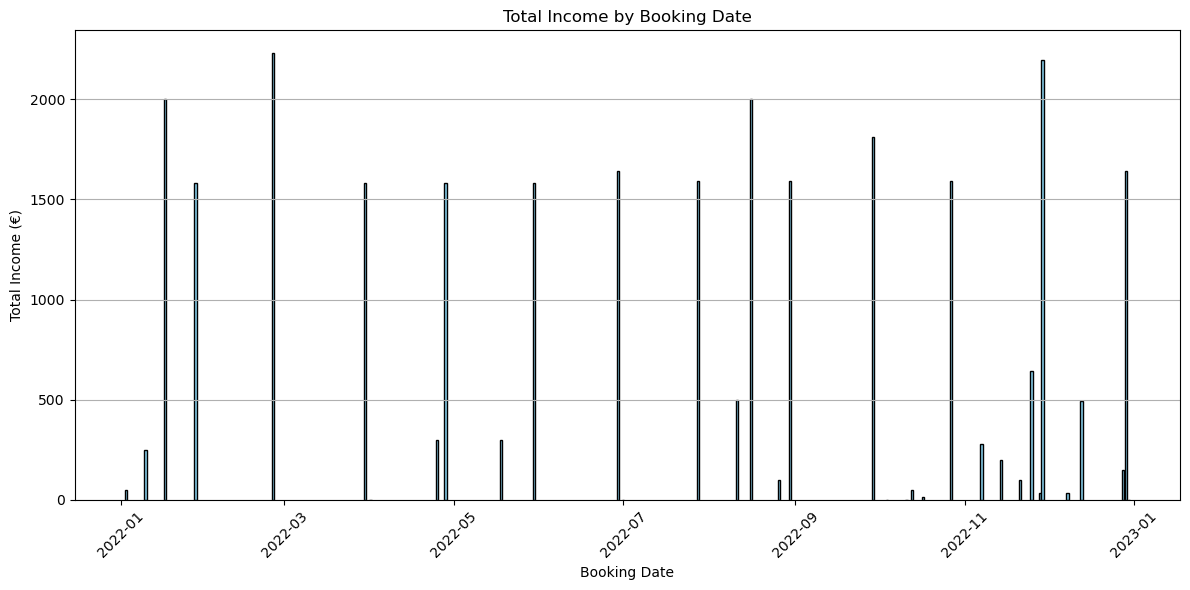

In [61]:
# Step 1: Filter the DataFrame for income entries
income_data = df[df['Umsatztyp'] == 'Eingang']

# Step 3: Group by Buchungsdatum and sum the Betrag (€) to get total income per date
total_income_per_date = income_data.groupby('Buchungsdatum')['Betrag (€)'].sum().reset_index()

# Step 4: Plotting the total income by booking date
plt.figure(figsize=(12, 6))
plt.bar(total_income_per_date['Buchungsdatum'], total_income_per_date['Betrag (€)'], color='skyblue', edgecolor='black')
plt.title('Total Income by Booking Date')  # Title of the plot
plt.xlabel('Booking Date')  # X-axis label
plt.ylabel('Total Income (€)')  # Y-axis label
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.grid(axis='y')  # Add grid lines to y-axis
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

Data type of amounts: float64
    Year  Month  Betrag (€)
0   2022      1     3883.19
1   2022      2     2233.19
2   2022      3     1583.19
3   2022      4     1883.19
4   2022      5     1883.19
5   2022      6     1643.73
6   2022      7     1593.28
7   2022      8     4193.28
8   2022      9     1814.28
9   2022     10     1657.25
10  2022     11     3450.92
11  2022     12     2317.55


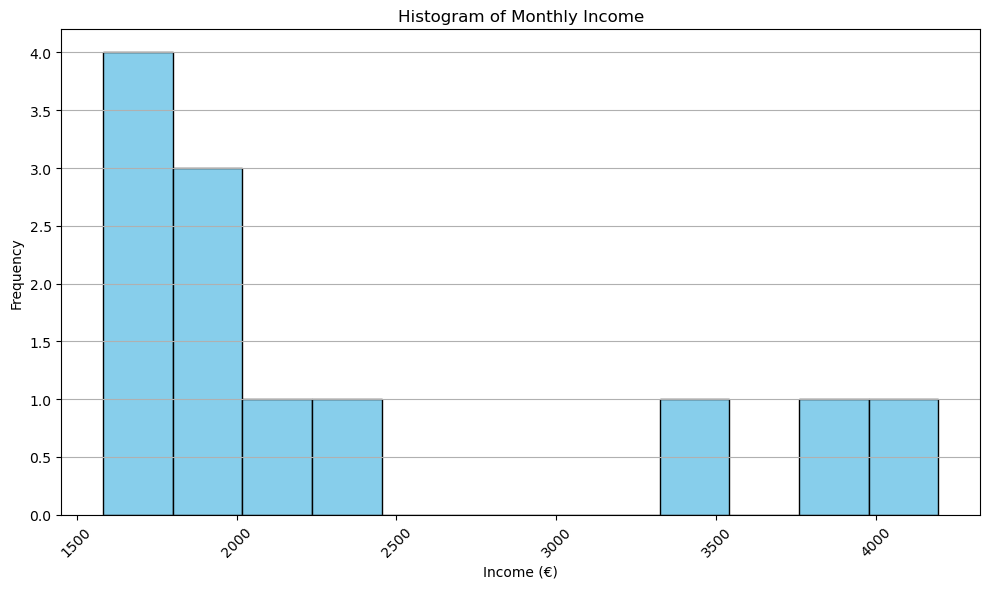

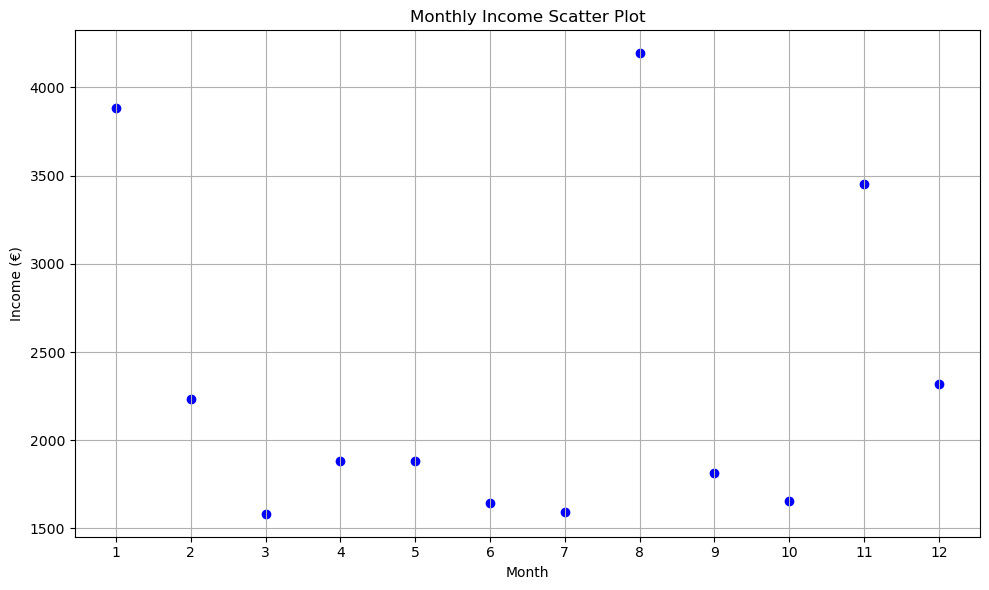

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        12 non-null     int32  
 1   Month       12 non-null     int32  
 2   Betrag (€)  12 non-null     float64
dtypes: float64(1), int32(2)
memory usage: 320.0 bytes
None


In [62]:
# Step 1: Filter the DataFrame for income transactions
income = df[df['Umsatztyp'] == 'Eingang']  # Filter for 'Income' transactions

# Step 2: Convert the 'Buchungsdatum' to datetime format
income['Buchungsdatum'] = pd.to_datetime(income['Buchungsdatum'], errors='coerce')  # Coerce errors to NaT

# Step 3: Extract Year and Month from the 'Buchungsdatum'
income['Year'] = income['Buchungsdatum'].dt.year
income['Month'] = income['Buchungsdatum'].dt.month

# Step 4: Sum the amounts by Year and Month
income_aggregated = income.groupby(['Year', 'Month'])['Betrag (€)'].sum().reset_index()

# Remove rows with NaN in the 'Betrag (€)' column
income_aggregated.dropna(subset=['Betrag (€)'], inplace=True)

# Debugging: Print the data type and the aggregated DataFrame
print("Data type of amounts:", income_aggregated['Betrag (€)'].dtype)
print(income_aggregated)


# Step: Create a histogram of income amounts
plt.figure(figsize=(10, 6))
plt.hist(income_aggregated['Betrag (€)'], bins=len(income_aggregated['Month']), color='skyblue', edgecolor='black')  # Histogram
plt.title('Histogram of Monthly Income')  # Title of the plot
plt.xlabel('Income (€)')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(rotation=45)  # Rotate x-ticks if necessary
plt.grid(axis='y')  # Add grid lines to y-axis
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

# Step: Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(income_aggregated['Month'], income_aggregated['Betrag (€)'], color='blue', marker='o')  # Scatter plot
plt.title('Monthly Income Scatter Plot')  # Title of the plot
plt.xlabel('Month')  # X-axis label
plt.ylabel('Income (€)')  # Y-axis label
plt.xticks(income_aggregated['Month'])  # Set x-ticks to show each month
plt.grid(True)  # Add grid lines
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

print(income_aggregated.info())

### Read csv
Works for DKB csv as of 2022-12-31.

In [63]:
# Read metadata
with open(csv_file,"r",encoding="latin-1") as f:
    reader = csv.DictReader(f,delimiter=";")
    metadata = {}
    for i, row in enumerate(reader):
        if i < 3:
            key = None
            value = None
            for k, v in row.items():
                if k == "Kontonummer:":
                    key = row["Kontonummer:"]
                    continue
                if k == "":
                    continue
                value = v
            
            if ":" in key:
                key = key.replace(":","")
            if "Kontostand" in key:
                key = "Kontostand"
            if "EUR" in value:
                value = value.replace(" ","").replace("EUR","")

            metadata[key] = value
            
# print(metadata)

start_date = datetime.strptime(metadata["Von"],"%d.%m.%Y").date()
end_date = datetime.strptime(metadata["Bis"],"%d.%m.%Y").date()
end_balance = float(metadata["Kontostand"].replace(".","").replace(",","."))

NameError: name 'csv_file' is not defined

In [ ]:
print("start:",start_date)
print("end:",end_date)
print("end balance:",end_balance)

## Named Columns

In [ ]:
party = "Auftraggeber / Begünstigter"
category = "Kategorie"
amount = "Betrag (EUR)"
cause = "Verwendungszweck"
posting_text = "Buchungstext"
balance = "Kontostand (EUR)"

### Cleanup

In [ ]:
# Fix US / EU decimal-point/comma
data[amount] = data[amount].str.replace('.','')
data[amount] = data[amount].str.replace(',','.')
data[amount] = data[amount].astype('float')

# avoid nan being interpreted as float in specific columns
data[party] = data[party].astype(str)
data[cause] = data[cause].astype(str)
data[posting_text] = data[posting_text].astype(str)

In [ ]:
data.head()

### Remove small transactions to avoid noise

In [ ]:
data = data[abs(data[amount]) > 0.01]

### Inverse Dataframe to have first day first and filter by time-range

In [ ]:
from dateutil.relativedelta import relativedelta
if number_of_last_months_to_analyse > 0:
    start_date = end_date - relativedelta(months=number_of_last_months_to_analyse)
    
print(f"Analysing time range: {start_date} -> {end_date}")
data = data.loc[str(start_date):str(end_date)]
data = data.iloc[::-1]

In [ ]:
fr = data.index[0]
to = data.index[-1]
print(fr,"->",to)

### Compute balance at each transaction

In [ ]:
data_balance = data[amount].sum().round(2)
start_balance = end_balance - data_balance
data[balance] = data[amount].cumsum()+start_balance

In [ ]:
print("start",start_balance)
print("end",end_balance)
print("balance during csv timespan",data_balance)

## Balance over time

In [ ]:
data[balance].plot(
    title='Account balance DKB %s' % accountname,
    grid=True,
    figsize=(20,8)
);

## Breakdown by transaction party

In [ ]:
empfgroup = data.groupby(party).agg({amount:"sum"})

In [ ]:
# Short the names
empfgroup.index = [str(i)[:30] for i in empfgroup.index]

In [ ]:
empfgroup[amount].head()

In [ ]:
empfgroup = empfgroup.sort_values(amount,ascending=False)
gutschrift = empfgroup[amount] > 0
colors = list( map(lambda x: "g" if x else "r" , gutschrift) )

In [ ]:
empfgroup[empfgroup[amount].abs() > 50].plot.barh(
    figsize=(10,60),
    title=u'Aggregierte Zahlungen ab 50€ (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
  );

In [ ]:
data.head()

# Idee wie mit torch ein modell trainiert wird das mir die categorisierung abnehmen kann 

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Beispiel-Daten für Verwendungszwecke und Kategorien
texts = ["Kauf bei Amazon", "Krankenhauskosten", "Taxi-Gebühr", "Lebensmitteleinkauf", "Spende an WWF"]
labels = [2, 0, 1, 3, 4]  # Beispiel-Kategorien: 0 = Gesundheit, 1 = Transport, 2 = Online-Handel, 3 = Lebensmittel, 4 = Spenden

# Kategorien festlegen
category_names = ["Gesundheit", "Transport", "Online-Handel", "Lebensmittel", "Spenden"]

# Tokenizer und Modell laden
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=len(category_names))

# Daten als Dataset formatieren
class PurposeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {key: val.squeeze() for key, val in encoding.items()}, torch.tensor(label)

# Train- und Test-Daten erstellen
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

train_dataset = PurposeDataset(train_texts, train_labels, tokenizer)
val_dataset = PurposeDataset(val_texts, val_labels, tokenizer)

# Training konfigurieren
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Training durchführen
trainer.train()

# Beispiel für die Kategorisierung neuer Texte
def classify_text(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
    outputs = model(**encoding)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return category_names[predicted_class_id]

# Beispiel-Anwendung
new_text = "Zahlung an die Krankenkasse"
print(f"Kategorie für '{new_text}': {classify_text(new_text)}")


## Breakdown by Category
We use some heuristics on the tranasaction details to put them into different categories.
All transactions within a category will be aggregated for a better overall analysis.
You may need to check the print output of the next cell and possibly adapt the mapping function for a better categorisation.

**the text will be lower cased before categorisation**

**Feel free to change these heuristic mappings - or adapt the code to map according to specififc transaction details.**

In [ ]:
categories = {
    "eat_out_or_get_food": [
        "restaurant",
        "gastro",
        "dean david",
        "cafe",
        "baeckerei",
        "coffee fellows",
        "jim block",
        "don qui",
        "Osteria",
        "subway",
        "backhaus",
        "burger king",
        "campus suite",
        "juice.more",
        "Backerei",
        "Avni Terhani",
        "vegan",
        "thai",
        "indisch",
    ],
    "alltag_laden": [
        "lidl",
        "aldi",
        "edeka",
        "alnatura",
        "rewe",
        "vollcorner",
    ],
    "spezial_laden": [
        "karstadt",
        "galeria",
        "kaufhof",
        "mueller",
        "migros",
        "coop",
        "dm fil",
        "go asia",
        "Drogerie",
        "SUCKFUELL",
        "butlers",
        "Suckfull",
        "Bio-Market",
        "conrad m",
    ],
    "online_handel":[
        "otto",
        "conrad elec",
        "amzn mktp",
        "amazon",
    ],
    "transport": [
        "FERNVERKEHR",
        "flixbus",
        "PAYPAL .DBVERTR",
    ],
    "ausflug": [
        "hamburg",
        "Hotel",
        "PAYPAL .booking",
        "prague",
        "praha",
        "Tubingen",
    ],
    "project": [
        "openai",
        "google.cloud",
        "github",
    ],
    "freizeit": [
        "VOLKSBAD",
        "PAYPAL .SENNHEISER",
    ],
    "entertainment": [
        "magellan",
        "Amazon Prime",
        "paypal .steam",
        "netflix"
    ],
    "crypto": [
        "bitflyer",
        "coinbase"
    ],
    "health": [
        "apotheke",
        "Krankenversicherung",
    ],
    "cash": [
        "bargeld",
        "automat",
        "cash"
    ],
    "dkb": [
        "DKB",
        "KREDITBANK",
    ],
    "miete": [],
    "investment": [],
    "emergency_fund":[],
    "uncategorized": [
        "PayPal (Europe)",
    ],
    "card_payment": [],
    "minor": [ # populated automatically
    ]
}

def mapToCategory(x):
    # use these transaction details to map to a category
    p = x[party].lower()
    pt = x[posting_text].lower()
    c = x[cause].lower()
    
    # manual mappings
    if "WERTP. ABRECHN".lower() in c or "Depot ".lower() in c or "WERTPAPIER".lower() in c:
        return "investment"
    
    if "miete ".lower() in c:
        return "miete"
    
    if "KREDITKARTENABRECHNUNG".lower() in c:
        return "card_payment"
    
    # mappings by category
    for cat, cat_words in categories.items():
        if any(map(lambda r: r.lower() in p, cat_words)) or any(map(lambda r: r.lower() in pt, cat_words)):
            return cat
    
    # debitcard. may need adaptation
    if "Debitk.20 VISA Debit".lower() in c:
        return "card_payment"
    
    return p

data[category] = data.apply(lambda x: mapToCategory(x), axis=1)

print(len(data[category].unique()),"categories")

print("============ uncategorized =================")
s = 0
for x in data[category].unique():
    ok = False
    
    for cat in categories.keys():
        if x == cat:
            ok = True

    if not ok:
        print(x)
        idx = data[category] == x
        s = s + abs(data[idx][amount].sum())
        
print("================================ sum of uncategorized: ",s) # todo. this doesn't seem to make sense ... 🤔

Breakdown by category. (Ignored transactions below 10€).

In [ ]:
byCategory = data.groupby(category).agg({amount:"sum"}).sort_values(amount,ascending=False)
byCategory = byCategory[abs(byCategory[amount]) > 10]
    

costs = byCategory[byCategory[amount] < 0]
costs.loc[:,amount] = -costs[amount]

total_costs = costs[amount].sum()
costs.plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    autopct=lambda x: str(round(x/100*total_costs)) + "€ | " + str(round(x)) + "%",
    title=u'Nach Kategorie Aggregierte Kosten (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()

byCategory[byCategory[amount] > 0].plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    title=u'Nach Kategorie Aggregiertes Einkommen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


byCategory.plot.barh(
    figsize=(6,40),
    grid=True,
    title=u'Nach Kategorie Aggregierte Zahlungen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


### Category analysis

In [ ]:
def quick_category_analyse(cat,desc=party):
    excursions = data[data[category] == cat].sort_values(amount,ascending=True)

    excursions.plot.barh(
        figsize=(12,12),
        x=desc,
        y=amount,
        legend=None,
    )
    plt.show()

    return excursions

In [ ]:
quick_category_analyse("investment",desc=cause)

In [ ]:
quick_category_analyse("dkb", desc=cause)

In [ ]:
quick_category_analyse("ausflug")

In [ ]:
quick_category_analyse("card_payment")

In [ ]:
quick_category_analyse("transport")